## Setup

In [1]:
%load_ext autoreload
%autoreload 2

import net
import logic
from data.load import load_genx

from collections import defaultdict
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt

import seaborn as sns
sns.set(font_scale=2)
sns.set_style("ticks")
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

## Model

In [2]:
# model configuration

N_HIDDEN = 256
N_COMM = 64
N_BATCH = 100
MAX_ITEMS = 20

RESTORE = False
SAVE = True

In [3]:
def build_model(dataset):
    # object feature observations
    t_features = tf.placeholder(tf.float32, (None, MAX_ITEMS, len(dataset.attrs)))
    
    # whether each object is contained within the target set
    t_labels = tf.placeholder(tf.float32, (None, MAX_ITEMS))

    # encoder observes both object features and target labels
    t_in = tf.concat((t_features, tf.expand_dims(t_labels, axis=2)), axis=2)

    cell = tf.contrib.rnn.GRUCell(N_HIDDEN)
    with tf.variable_scope("enc1"):
        states1, hidden1 = tf.nn.dynamic_rnn(cell, t_in, dtype=tf.float32)
    t_hidden = hidden1
    t_msg = tf.nn.relu(net.linear(t_hidden, N_COMM))

    # decoder makes independent predictions for each set of object features
    t_expand_msg = tf.expand_dims(t_msg, axis=1)
    t_tile_message = tf.tile(t_expand_msg, (1, MAX_ITEMS, 1))
    t_out_feats = tf.concat((t_tile_message, t_features), axis=2)
    t_pred = tf.squeeze(
        net.mlp(t_out_feats, (N_HIDDEN, 1), (tf.nn.relu, None)))
    t_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            labels=t_labels, logits=t_pred))

    return t_features, t_labels, t_msg, t_pred, t_loss

## Training & Evaluation

In [4]:
random = np.random.RandomState(0)
tf.set_random_seed(0)

dataset = load_genx()
t_features, t_labels, t_msg, t_pred, t_loss = build_model(dataset)
optimizer = tf.train.AdamOptimizer(0.001)
o_train = optimizer.minimize(t_loss)
session = tf.Session()
session.run(tf.global_variables_initializer())

# collect logical forms appearing in train and test

train_lfs = []
for scene_id in dataset.train_ids:
    for label in dataset.labels[scene_id]:
        train_lfs.append(label.lf)
random.shuffle(train_lfs)
        
test_lfs = []
for scene_id in dataset.test_ids:
    for label in dataset.labels[scene_id]:
        test_lfs.append(label.lf)
random.shuffle(test_lfs)

In [5]:
negated = [lf for lf in train_lfs if "not" in logic.tokens(lf)]
print "%.2f%% of train LFs involve negation" % (100. * len(negated) / len(train_lfs))

21.24% of train LFs involve negation


In [6]:
if RESTORE:
    saver = tf.train.Saver()
    saver.restore(session, "saves/model")

In [7]:
# this cell contains various helper functions used for training

# create a new random LF with the same high-level structure as the input LF
def randomize_lf(lf, attrs_by_type):
    if isinstance(lf, str): # at a leaf
        if ":" not in lf: # leave ordinary functions intact
            return lf
        typ = lf.split(":")[1] # replace attribute literals with others of same type
        return random.choice(attrs_by_type[typ])
    return [randomize_lf(l, attrs_by_type) for l in lf]

# generate a set of random nontrivial environments labeled with the given LFs
def sample_envs(dataset, lfs, randomize=False):
    # sort primitive predicates by type
    # (kludge---this should be a property of the dataset)
    attrs_by_type = defaultdict(list)
    for attr in dataset.attrs:
        typ = attr.split(":")[1]
        attrs_by_type[typ].append(attr)
        
    envs = np.zeros((len(lfs), MAX_ITEMS, len(dataset.attrs)))
    labels = np.zeros((len(lfs), MAX_ITEMS))
    
    i_env = 0
    i_attempt = 0
    while i_env < len(lfs):
        # pick the logical form to use for labeling
        if randomize:
            template_lf = lfs[i_env]
            lf = randomize_lf(template_lf, attrs_by_type)
        else:
            lf = lfs[i_env]
            
        # generate a bunch of random objects
        count = random.randint(MAX_ITEMS)
        for i_item in range(count):
            attrs = np.zeros(len(dataset.attrs))
            for group in attrs_by_type.values():
                val = random.choice(group)
                attrs[dataset.attrs[val]] = 1
            envs[i_env, i_item, :] = attrs
            if logic.eval_lf(attrs, lf, dataset):
                labels[i_env, i_item] = 1
                
        i_attempt += 1
        
        # if the labeling is trivial, try again
        if (not labels[i_env, :].any()) or labels[i_env, :count].all():
            envs[i_env, :, :] = 0
            labels[i_env, :] = 0
            if i_attempt < 10:
                continue
                
        i_env += 1
    
    return envs, labels

# load the scenes with the given ids from the dataset
def sample_annotated(dataset, scene_ids):
    envs = np.zeros((len(scene_ids), MAX_ITEMS, len(dataset.attrs)))
    labels = np.zeros((len(scene_ids), MAX_ITEMS))
    for i_env, scene_id in enumerate(scene_ids):
        scene = dataset.scenes[scene_id]
        i_item = 0
        for target in scene.targets:
            for prop in target.props:
                envs[i_env, i_item, dataset.attrs[prop]] = 1
            labels[i_env, i_item] = 1
            i_item += 1
            
        for distractor in scene.distractors:
            for prop in distractor.props:
                envs[i_env, i_item, dataset.attrs[prop]] = 1
            i_item += 1
            
    return envs, labels

In [8]:
# compute accuracy on training data
acc_history = []
exact_history = []
def eval_labeled():
    scene_ids = dataset.train_ids
    acc = 0.
    exact = 0.
    for i in range(0, len(scene_ids), N_BATCH):
        batch_ids = scene_ids[i:i+N_BATCH]
        envs, labels = sample_annotated(dataset, batch_ids)
        preds, = session.run([t_pred], {t_features: envs, t_labels: labels})
        match = (preds > 0) == labels
        acc += np.sum(np.mean(match, axis=1))
        exact += np.sum(np.all(match, axis=1))
    acc /= len(scene_ids)
    exact /= len(scene_ids)
    acc_history.append(acc)
    exact_history.append(exact)
    
    from IPython import display
    display.clear_output(wait=True)
    plt.clf()
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(range(len(acc_history)), acc_history)
    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(range(len(exact_history)), exact_history)
    plt.show()

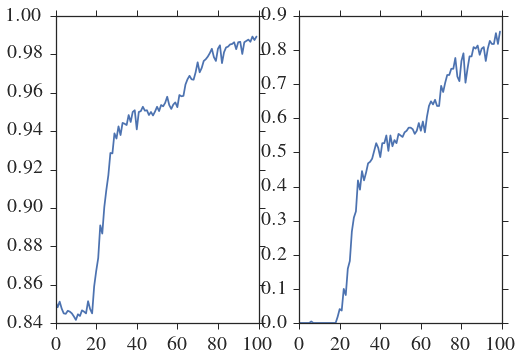

In [9]:
random = np.random.RandomState(1)

for epoch in range(100):
    loss = 0
    acc = 0
    ex = 0
    for t in range(100):
        batch_lfs = [train_lfs[random.randint(len(train_lfs))] for _ in range(N_BATCH)]
        envs, labels = sample_envs(dataset, batch_lfs, randomize=True)
        l, preds, _ = session.run(
                [t_loss, t_pred, o_train],
                {t_features: envs, t_labels: labels})
        match = (preds > 0) == labels
        a = np.mean(match)
        e = np.mean(np.all(match, axis=1))
        loss += l
        acc += a
        ex += e
        
    eval_labeled()

In [10]:
if SAVE:
    saver = tf.train.Saver()
    saver.save(session, "saves/model")

## Analysis

In [25]:
# this cell contains helper functions used for analysis

N_SAMPLE = 10

# the literal theory: return true if this object exactly matches any object
# in the target set for the stimulus environment
def literal_pred(item, stim_env, stim_labels):
    if not item.any():
        return False
    return any(
        (stim_env[0, j, :] == item).all() and stim_labels[0, j] == 1
        for j in range(stim_env.shape[1])
    )

# the inverse literal theory: return true if this object doesn't match any
# object in the target set for the stimulus environment
def inv_literal_pred(item, stim_env, stim_labels):
    if not item.any():
        return False
    return not any(
        (stim_env[0, j, :] == item).all() and stim_labels[0, j] == 1
        for j in range(stim_env.shape[1])
    )

# the random theory
def random_pred(item):
    if not item.any():
        return False
    return random.randint(2)

# count how often each of the provided predictors / "theories" agrees with the
# decoder for the given message on environments sampled from provided scene_ids
#
# accumulates results into scene_agreements, table_agreements, item_agreements
def count_equiv(msg, n_sample, predictors, scene_agreements, table_agreements,
                item_agreements, scene_ids):
    # broadcast the input message over scenes
    tile_msg = np.asarray([msg for _ in range(n_sample)])
    
    # sample environments from the given scene ids
    envs, _ = sample_annotated(dataset, random.choice(scene_ids, size=n_sample).tolist())
    
    # compute model predictions
    model_preds, = session.run([t_pred], {t_features: envs, t_msg: tile_msg})
    
    # compute theory agreement with  model predictions
    for name, predictor in predictors.items():
        preds = np.zeros((n_sample, MAX_ITEMS))
        n_agree_items = 0
        n_total_items = 0
        for i_samp in range(n_sample):
            for i_item in range(MAX_ITEMS):
                preds[i_samp, i_item] = predictor(envs[i_samp, i_item, :])
                # compute agreement for this item
                if envs[i_samp, i_item, :].any():
                    n_total_items += 1
                    if preds[i_samp, i_item] == (model_preds > 0)[i_samp, i_item]:
                        n_agree_items += 1
                
        # scene-level agreement
        scene_agreements[name] += np.mean(np.all((model_preds > 0) == preds, axis=1))
        # table-level agreement
        table_agreements[name] += ((model_preds > 0) == preds).all()
        # item-level agreement
        item_agreements[name] += 1. * n_agree_items / n_total_items

# EVALUATE high-level model behavior on the given scenes or the given lfs.
# Used for the evaluation in Section 4.
#
# _sentinel: prevent me from screwing up the argument order
# scene_ids: scenes to use as stimulus environments
# lfs: logical forms to use when synthesizing stimulus environments
# sample_ids: scenes to use for generating tabular meaning representation
# one of scene_ids or lfs must be provided
def check_agreement(_sentinel=None, scene_ids=None, lfs=None, sample_ids=None):
    assert _sentinel is None
    assert not (scene_ids is None and lfs is None)
    assert (scene_ids is None) or (lfs is None)
    assert sample_ids is not None
    matches = []
    
    scene_agreements = defaultdict(lambda: 0)
    table_agreements = defaultdict(lambda: 0)
    item_agreements = defaultdict(lambda: 0)
    n_successes = 0
    n_ref_successes = 0
    
    # prepare stimulus environments
    if scene_ids is not None:
        all_stim_envs, all_stim_labels = sample_annotated(dataset, scene_ids)
        n_use = len(scene_ids)
    else:
        all_stim_envs, all_stim_labels = sample_envs(dataset, lfs)
        n_use = len(lfs)
    
    for i_stim in range(n_use):
        stim_env = all_stim_envs[i_stim:i_stim+1, ...]
        stim_labels = all_stim_labels[i_stim:i_stim+1, ...]
        
        # collect all the logical forms used to annotate this scene
        if scene_ids is not None:
            scene_lfs = [l.lf for l in dataset.labels[scene_ids[i_stim]]]
        else:
            scene_lfs = [lfs[i_stim]]
        
        # count how often each lf was provided in annotations
        lf_counts = defaultdict(lambda: [None, 0])
        for lf in scene_lfs:
            lf_counts[str(lf)][0] = lf
            lf_counts[str(lf)][1] += 1
        
        consensus_lf = max(lf_counts.values(), key=lambda x: x[1])[0]
        shortest_lf = min(lf_counts.values(), key=lambda x: len(logic.tokens(x[0])))[0]
        predictors = {
            "random": lambda item: random_pred(item),
            "consensus": lambda item: logic.eval_lf(item, consensus_lf, dataset),
            "shortest": lambda item: logic.eval_lf(item, shortest_lf, dataset),
            "literal": lambda item: literal_pred(item, stim_env, stim_labels),
            "inv-literal": lambda item: inv_literal_pred(item, stim_env, stim_labels)
        }
        
        # verify gold logical form accuracy
        stim_lf_pred = [
            logic.eval_lf(stim_env[0, i_item, :], consensus_lf, dataset)
            for i_item in range(MAX_ITEMS)]
        if np.all(stim_labels == stim_lf_pred):
            n_ref_successes += 1
        
        # compute encoder message
        msg, stim_pred = session.run(
            [t_msg, t_pred], {t_features: stim_env, t_labels: stim_labels})
        msg = msg[0, :]
        
        # verify model accuracy
        if ((stim_pred > 0) == stim_labels).all():
            n_successes += 1
        
        # accumulate fine-grained evaluation results
        count_equiv(msg, N_SAMPLE, predictors, scene_agreements,
                    table_agreements, item_agreements, sample_ids)
            
    print "ref accuracy: %0.2f" % (1. * n_ref_successes / n_use)
    print "model accuracy: %0.2f" % (1. * n_successes / n_use)
    print "scene agreement:  "
    for name, score in scene_agreements.items():
        print "    %s: %0.2f" % (name, 1. * score / n_use)
    print "table agreement:"
    for name, score in table_agreements.items():
        print "    %s: %0.2f" % (name, 1. * score / n_use)
    print "item agreement:"
    for name, score in item_agreements.items():
        print "    %s: %0.2f" % (name, 1. * score / n_use)
        
# EVALUATE compositional model behavior.
# This function serves two purposes: as a data collection tool, it mines for
# pairs of messages and logical forms that carry the same semantics. As an
# evaluation tool, it measures agreement between the provided LF transformation
# function and the provided message vector transformation function. Used for
# the evaluation in Section 5.
#
# lf_groups: input groups of logical forms (to be negated, disjoined, etc.)
# sample_ids: scenes to use for generating tabular meaning representation
# lf_transform: the function to use for transforming input logical forms
# msg_transform: the function to use for transforming message vectors
# enforce_init: ensure that input message vectors and LFs have the same 
#               semantics
# enforce_equiv: like enforce_init, but also ensure that messages collected
#                from labels produced by transformed LFs carry the same
#                semantics as the transformed LFs themselves. (See page 4.)
#         
# require_trans: require the transformed LF to return true on at least this
#                many inputs (to avoid trivial samples)
def check_transform(lf_groups, sample_ids, lf_transform=None,
                    msg_transform=None, enforce_equiv=False,
                    enforce_init=False, require_trans=0):
    assert lf_transform is not None
    if enforce_equiv: assert msg_transform is None
    
    pairs = []
    i_lf = 0
    i_attempt = 0
    agree_stim = 0.
    scene_agreements = defaultdict(lambda: 0.)
    table_agreements = defaultdict(lambda: 0.)
    item_agreements = defaultdict(lambda: 0)
    while len(pairs) < len(lf_groups):
        # if one of the force_ options is on, we're collecting data rather than
        # running a final evaluation, so we can sample for lfs that work rather
        # than trying to use everything once
        if enforce_equiv or enforce_init:
            lf_group = lf_groups[random.randint(len(lf_groups))]
        else:
            lf_group = lf_groups[i_lf]
            
        # select a stimulus environment
        stim_env, _ = sample_annotated(dataset, [random.choice(sample_ids)])
        trans_lf = lf_transform(lf_group)
        # compute base LF predictions on stimulus
        stim_labels = [[
            logic.eval_lf(stim_env[0, i, :], lf, dataset) 
            for i in range(MAX_ITEMS)] 
            for lf in lf_group]
        stim_labels = np.asarray(stim_labels)
        # compute transformed LF predictions on stimulus
        trans_labels = [[
            logic.eval_lf(stim_env[0, i, :], trans_lf, dataset) 
            for i in range(MAX_ITEMS)]]
        trans_labels = np.asarray(trans_labels)
        # skip stimuli where the transformed LF makes a trivial prediction
        # (thresholded by require_trans)
        if trans_labels.sum() < require_trans:
            continue
        
        # compute message and prediction on stimulus environment labeled with
        # each input LF
        msgs, preds = session.run(
            [t_msg, t_pred],
            {t_features: np.tile(stim_env, (len(lf_group), 1, 1)),
             t_labels: stim_labels})
        
        if msg_transform is None:
            # if we're not evaluating a transformation function, collect new
            # message and predictions on stimulus labeled with the transformed
            # LF
            trans_msg, trans_preds = session.run(
                [t_msg, t_pred],
                {t_features: stim_env, t_labels: trans_labels})
            trans_msg = trans_msg[0, :]
        else:
            # otherwise, just collect predictions on the stimulus using the
            # transformed message vector
            trans_msg = msg_transform(msgs)
            trans_preds, = session.run(
                [t_pred],
                {t_features: stim_env, t_msg: [trans_msg]})
            
        # SCORE ALL THE THINGS
        scene_agreements_here = defaultdict(lambda: 0)
        table_agreements_here = defaultdict(lambda: 0)
        item_agreements_here = defaultdict(lambda: 0)
        count_equiv(
                trans_msg, N_SAMPLE,
                {
                    "human": lambda item: logic.eval_lf(item, trans_lf, dataset),
                    "literal": lambda item: literal_pred(item, stim_env, trans_labels),
                    "inv-literal*": lambda item: inv_literal_pred(
                        item, stim_env, stim_labels),
                    "and-literal*": lambda item: literal_pred(
                        item, stim_env, np.min(stim_labels, axis=0, keepdims=True)),
                    "or-literal*": lambda item: literal_pred(
                        item, stim_env, np.max(stim_labels, axis=0, keepdims=True)),
                    "random": lambda item: random_pred(item)
                },
                scene_agreements_here, table_agreements_here, item_agreements_here, sample_ids)
            
        # data collection filters
        if enforce_equiv or enforce_init:
            i_attempt += 1
            enforce_scene = defaultdict(lambda: 0)
            enforce_table = defaultdict(lambda: 0)
            enforce_item = defaultdict(lambda: 0)
            for i_msg in range(len(lf_group)):
                count_equiv(
                        msgs[i_msg, ...], 10,
                        {"_": lambda item: logic.eval_lf(item, lf_group[i_msg], dataset)},
                        enforce_scene, enforce_table, enforce_item, sample_ids)
            # in any enforce mode, at least ensure that the input message
            # vector agrees with input LFs on all sampled scenes
            if enforce_table["_"] < len(lf_group):
                continue
            # if enforcing full equivalence, also require that the output
            # message agrees with the transformed LF on all sampled scenes
            if enforce_equiv and table_agreements_here["human"] < 1:
                continue
            # this could take a while
            if len(pairs) % 100 == 0:
                print len(pairs), "/", len(lf_groups)
        
        # model accuracy on transformed stimulus labels
        if ((trans_preds > 0) == trans_labels).all():
            agree_stim += 1
            
        for k in table_agreements_here:
            scene_agreements[k] += scene_agreements_here[k]
            table_agreements[k] += table_agreements_here[k]
            item_agreements[k] += item_agreements_here[k]
            
        pairs.append((msgs, trans_msg, lf_group))
        i_lf += 1
        i_attempt = 0
    
    n_use = len(lf_groups)
    print "agree after transform (stim): %0.2f" % (agree_stim / n_use)
    print "scene agreement:  "
    for name, score in scene_agreements.items():
        print "    %s: %0.2f" % (name, 1. * score / n_use)
    print "table agreement:"
    for name, score in table_agreements.items():
        print "    %s: %0.2f" % (name, 1. * score / n_use)
    print "item agreement:"
    for name, score in item_agreements.items():
        print "    %s: %0.2f" % (name, 1. * score / n_use)
    
    return pairs

In [12]:
# this cell contains helper functions for generating plots

from sklearn.decomposition import PCA

def visualize(matches, dest=None):
    messages = np.asarray([m[0] for m in matches])
    proj_msgs = PCA(2).fit_transform(messages)
    
    if len(matches[0]) == 3:
        colors = [m[2] for m in matches]
    else:
        colors = None
    
    plt.figure()
    plt.scatter(proj_msgs[:, 0], proj_msgs[:, 1], c=colors, s=50, linewidth=2)
    for i, m in enumerate(matches):
        lf = m[1]
        plt.text(proj_msgs[i, 0], proj_msgs[i, 1], logic.pp(lf))
    if dest is not None:
        plt.savefig(dest)
    plt.show()

In [22]:
# GENERATES TABLE 1

random = np.random.RandomState(2)

all_scene_ids = dataset.test_ids

print "TABLE 1\n"
check_agreement(scene_ids=all_scene_ids, sample_ids=dataset.test_ids)

TABLE 1

ref accuracy: 1.00
model accuracy: 0.91
scene agreement:  
    consensus: 0.63
    inv-literal: 0.00
    literal: 0.27
    random: 0.00
    shortest: 0.57
table agreement:
    consensus: 0.35
    inv-literal: 0.00
    literal: 0.05
    random: 0.00
    shortest: 0.33
item agreement:
    consensus: 0.92
    inv-literal: 0.26
    literal: 0.74
    random: 0.49
    shortest: 0.91


In [23]:
# do we do better on scenes annotated with simple predicates?

random = np.random.RandomState(3)

primitive_scene_ids = []
for scene_id in dataset.test_ids:
    labels = dataset.labels[scene_id]
    if any(isinstance(label.lf, str) for label in labels):
        primitive_scene_ids.append(scene_id)
        
check_agreement(scene_ids=primitive_scene_ids, sample_ids=dataset.test_ids)

ref accuracy: 1.00
model accuracy: 0.94
scene agreement:  
    consensus: 0.73
    inv-literal: 0.00
    literal: 0.48
    random: 0.00
    shortest: 0.61
table agreement:
    consensus: 0.44
    inv-literal: 0.00
    literal: 0.00
    random: 0.00
    shortest: 0.39
item agreement:
    consensus: 0.95
    inv-literal: 0.08
    literal: 0.92
    random: 0.53
    shortest: 0.92


In [26]:
# GENERATES Table 2 (Neg)

random = np.random.RandomState(4)

fit_lfs = [[lf] for lf in train_lfs[:500]]
eval_lfs = [[lf] for lf in test_lfs]

# experiments in the paper involve held-out stimulus environments, possibly
# labeled with logical forms that also appear in the training set

# we could alternatively evaluate on held-out *logical forms*---scores are
# worse but trends are similar
#
# eval_lfs = [e for e in eval_lfs if e not in fit_lfs]

# prepare the negation function
lf_negate = lambda lfs: ["not", lfs[0]]

# this experiment is not included in the paper

print "fit (don't enforce equivalence)"

pairs = []
for i_lf in range(0, len(fit_lfs), 500):
    args = fit_lfs[i_lf:i_lf+500]
    pairs += check_transform(
            args, dataset.train_ids, lf_transform=lf_negate)
x = np.asarray([p for (p,), n, l in pairs])
y = np.asarray([n for (p,), n, l in pairs])
op, residuals, rank, _ = np.linalg.lstsq(x, y)

print
print "eval (don't enforce equivalence)"
check_transform(eval_lfs, dataset.test_ids, lf_transform=lf_negate,
                msg_transform=lambda msgs: op.T.dot(msgs[0]))

# this one is

print
print "fit (enforce equivalence)"
equiv_pairs = []
for i_lf in range(0, len(fit_lfs), 500):
    args = fit_lfs[i_lf:i_lf+500]
    equiv_pairs += check_transform(
            args, dataset.train_ids, lf_transform=lf_negate, enforce_equiv=True)
    
ex = np.asarray([p for (p,), n, l in equiv_pairs])
ey = np.asarray([n for (p,), n, l in equiv_pairs])
eop, residuals, rank, _ = np.linalg.lstsq(ex, ey)

print
print "eval (enforce equivalence)"
print "TABLE 2 (NEG)"

_ = check_transform(
        eval_lfs, dataset.test_ids, lf_transform=lf_negate,
        msg_transform=lambda msgs: eop.T.dot(msgs[0]), enforce_init=True)

fit (don't enforce equivalence)
agree after transform (stim): 0.93
scene agreement:  
    inv-literal*: 0.36
    random: 0.00
    or-literal*: 0.02
    literal: 0.11
    and-literal*: 0.02
    human: 0.56
table agreement:
    inv-literal*: 0.22
    random: 0.00
    or-literal*: 0.00
    literal: 0.06
    and-literal*: 0.00
    human: 0.21
item agreement:
    inv-literal*: 0.75
    random: 0.50
    or-literal*: 0.25
    literal: 0.46
    and-literal*: 0.25
    human: 0.92

eval (don't enforce equivalence)
agree after transform (stim): 0.88
scene agreement:  
    inv-literal*: 0.36
    random: 0.00
    or-literal*: 0.02
    literal: 0.15
    and-literal*: 0.02
    human: 0.50
table agreement:
    inv-literal*: 0.21
    random: 0.00
    or-literal*: 0.00
    literal: 0.09
    and-literal*: 0.00
    human: 0.13
item agreement:
    inv-literal*: 0.75
    random: 0.50
    or-literal*: 0.25
    literal: 0.45
    and-literal*: 0.25
    human: 0.91

fit (enforce equivalence)
0 / 500
100 / 500
2

FIGURE 3A


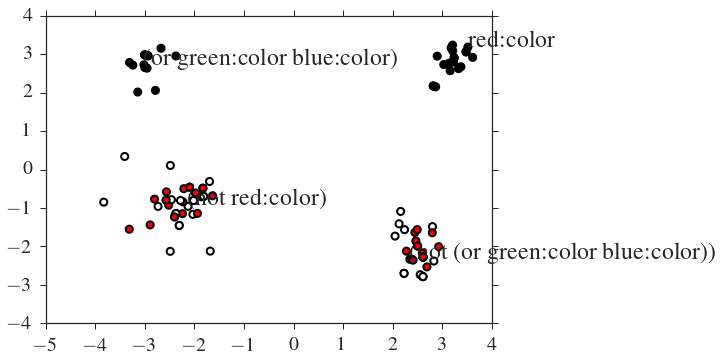

In [27]:
points = []
labels = []
colors = []
lf_counts = defaultdict(lambda: 0)

candidates = ("red:color", ["or", "green:color", "blue:color"])

for p, n, l in equiv_pairs:
    if l[0] in candidates and lf_counts[str(l[0])] < 20:
        if lf_counts[str(l[0])] == 0:
            labels.append(l[0])
            labels.append(lf_negate(l))
            labels.append("")
        else:
            labels += ["", "", ""]
            
        points.append(p[0])
        colors.append("k")
        
        points.append(n)
        colors.append("w")
        
        points.append(eop.T.dot(p[0]))
        colors.append("r")
        
        lf_counts[str(l[0])] += 1
        
print "FIGURE 3A"
visualize(zip(points, labels, colors), dest="fig_not_.pdf")

In [28]:
random = np.random.RandomState(5)

fit_lfs = train_lfs[:500]
fit_lfs_2 = list(fit_lfs)
random.shuffle(fit_lfs_2)
eval_lfs = test_lfs
eval_lfs_2 = list(eval_lfs)
random.shuffle(eval_lfs_2)

lf_disjoin = lambda lfs: ["or", lfs[0], lfs[1]]

print "fit"

equiv_pairs = []
for i_lf in range(0, len(fit_lfs), 500):
    args = zip(fit_lfs[i_lf:i_lf+500], fit_lfs_2[i_lf:i_lf+500])
    equiv_pairs += check_transform(
            args, dataset.train_ids, lf_transform=lf_disjoin, enforce_equiv=True)
ex1 = np.asarray([p1 for (p1, p2), n, l in equiv_pairs])
ex2 = np.asarray([p2 for (p1, p2), n, l in equiv_pairs])
ey = np.asarray([n for pp, n, l in equiv_pairs])
eop, residuals, rank, _ = np.linalg.lstsq((ex1 + ex2) / 2, ey)
print residuals, rank

print
print "eval"
print "TABLE 2 (DISJ)"

_ = check_transform(
        zip(eval_lfs, eval_lfs_2), dataset.test_ids, lf_transform=lf_disjoin, 
        msg_transform=lambda msgs: eop.T.dot((msgs[0] + msgs[1])/2), enforce_init=True)

fit
0 / 500
100 / 500
200 / 500
300 / 500
400 / 500
agree after transform (stim): 1.00
scene agreement:  
    inv-literal*: 0.06
    random: 0.00
    or-literal*: 0.11
    literal: 0.11
    and-literal*: 0.07
    human: 1.00
table agreement:
    inv-literal*: 0.00
    random: 0.00
    or-literal*: 0.03
    literal: 0.03
    and-literal*: 0.02
    human: 1.00
item agreement:
    inv-literal*: 0.45
    random: 0.50
    or-literal*: 0.59
    literal: 0.59
    and-literal*: 0.50
    human: 1.00
[] 56

eval
TABLE 2 (DISJ)
0 / 798
100 / 798
200 / 798
300 / 798
400 / 798
500 / 798
600 / 798
700 / 798
agree after transform (stim): 0.62
scene agreement:  
    inv-literal*: 0.03
    random: 0.00
    or-literal*: 0.09
    literal: 0.09
    and-literal*: 0.05
    human: 0.54
table agreement:
    inv-literal*: 0.00
    random: 0.00
    or-literal*: 0.01
    literal: 0.01
    and-literal*: 0.01
    human: 0.19
item agreement:
    inv-literal*: 0.46
    random: 0.50
    or-literal*: 0.58
    literal:

FIGURE 3B


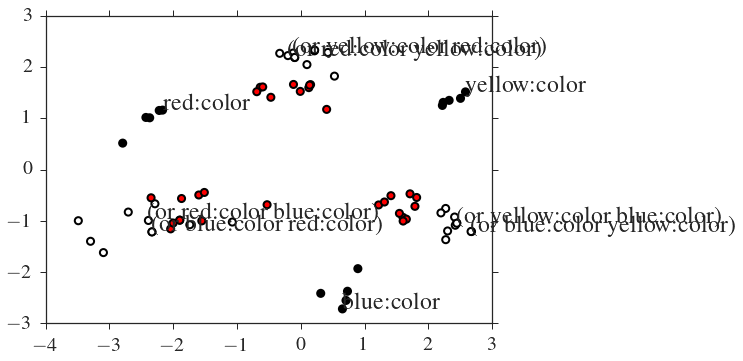

In [29]:
points = []
labels = []
colors = []
lf_counts = defaultdict(lambda: 0)

candidates = ("red:color", "yellow:color", "blue:color")
count = 5

for p, n, l in equiv_pairs:
    if l[0] in candidates and l[1] in candidates and l[0] != l[1]:
        if lf_counts[l[0]] < count:
            points.append(p[0])
            labels.append(l[0] if lf_counts[l[0]] == 0 else "")
            colors.append("k")
            lf_counts[l[0]] += 1
        if lf_counts[l[1]] < count:
            points.append(p[1])
            labels.append(l[1] if lf_counts[l[1]] == 0 else "")
            colors.append("k")
            lf_counts[l[1]] += 1
        if lf_counts[str(lf_disjoin(l))] < count:
            points.append(n)
            labels.append(lf_disjoin(l) if lf_counts[str(lf_disjoin(l))] == 0 else "")
            colors.append("w")
            lf_counts[str(lf_disjoin(l))] += 1
            
            points.append(eop.T.dot((p[0] + p[1]) / 2))
            labels.append("")
            colors.append("r")
            
print "FIGURE 3B"
visualize(zip(points, labels, colors), dest="fig_or_.pdf")

In [30]:
random = np.random.RandomState(6)

fit_lfs = train_lfs[:500]
fit_lfs_2 = list(fit_lfs)
random.shuffle(fit_lfs_2)
eval_lfs = test_lfs
eval_lfs_2 = list(eval_lfs)
random.shuffle(eval_lfs_2)

lf_conjoin = lambda lfs: ["and", lfs[0], lfs[1]]

print "fit"

equiv_pairs = []
for i_lf in range(0, len(fit_lfs), 500):
    args = zip(fit_lfs[i_lf:i_lf+500], fit_lfs_2[i_lf:i_lf+500])
    equiv_pairs += check_transform(
            args, dataset.train_ids, lf_transform=lf_conjoin, enforce_equiv=True, require_trans=2)
ex1 = np.asarray([p1 for (p1, p2), n, l in equiv_pairs])
ex2 = np.asarray([p2 for (p1, p2), n, l in equiv_pairs])
ey = np.asarray([n for pp, n, l in equiv_pairs])
eop, residuals, rank, _ = np.linalg.lstsq((ex1 + ex2) / 2, ey)
print residuals, rank

print
print "eval"
print "TABLE 2 (CONJ)"

_ = check_transform(
        zip(eval_lfs, eval_lfs_2), dataset.test_ids, lf_transform=lf_conjoin, 
        msg_transform=lambda msgs: eop.T.dot((msgs[0] + msgs[1])/2), enforce_init=True, require_trans=2)

fit
0 / 500
100 / 500
200 / 500
300 / 500
400 / 500
agree after transform (stim): 1.00
scene agreement:  
    inv-literal*: 0.00
    random: 0.00
    or-literal*: 0.11
    literal: 0.18
    and-literal*: 0.18
    human: 1.00
table agreement:
    inv-literal*: 0.00
    random: 0.00
    or-literal*: 0.00
    literal: 0.01
    and-literal*: 0.01
    human: 1.00
item agreement:
    inv-literal*: 0.23
    random: 0.50
    or-literal*: 0.73
    literal: 0.80
    and-literal*: 0.80
    human: 1.00
[] 58

eval
TABLE 2 (CONJ)
0 / 798
100 / 798
200 / 798
300 / 798
400 / 798
500 / 798
600 / 798
700 / 798
agree after transform (stim): 0.55
scene agreement:  
    inv-literal*: 0.00
    random: 0.00
    or-literal*: 0.10
    literal: 0.19
    and-literal*: 0.19
    human: 0.56
table agreement:
    inv-literal*: 0.00
    random: 0.00
    or-literal*: 0.01
    literal: 0.01
    and-literal*: 0.01
    human: 0.37
item agreement:
    inv-literal*: 0.22
    random: 0.50
    or-literal*: 0.73
    literal: